In [1]:
import warnings

from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In [70]:
# Wrangle function that returns a dataframe from a filepath

def wrangle(filepath):
    mexico_df = pd.read_csv(filepath, index_col=0)
    
    # Subset to properties in Distrito Federal
    mask_ba = mexico_df.place_with_parent_names.str.contains('Distrito Federal')
    # Subset to apartments only
    mask_apt = mexico_df.property_type == 'apartment'
    # Subset to price_aprox_usd < 400_000
    mask_price = mexico_df.price_aprox_usd < 400_000
    
    mexico_df = mexico_df[mask_ba & mask_apt & mask_price]
    
    # Removing Outliers by 'Surface_covered_in_m2'
    low, high = mexico_df['surface_covered_in_m2'].quantile([0.1,0.9])
    mask_area = mexico_df['surface_covered_in_m2'].between(low, high)
    mexico_df = mexico_df[mask_area]
    
    
    return mexico_df

In [71]:
mexico_df = wrangle('/Users/OWEN ADOM ASARE/Desktop/Projects/CSVs/mexico-city-real-estate-1.csv')

In [72]:
# Check your work
assert (
    len(mexico_df) <= 8606
), f"`df` should have no more than 8606 observations, not {len(mexico_df)}."

## First Subsets
For this project, we want to build a model for apartments in Mexico proper ("Distrito Federal") that cost less than $400,000. Looking at the first five rows of our DataFrame, we can already see that there properties that fall outside those parameters. So our first cleaning task is to remove those observations from our dataset. Since we're using a function to import and clean our data, we'll need to make changes there.

In [73]:
mexico_df.head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
1,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"23.634501,-102.552788",5500000.0,MXN,5450245.50,289775.66,NaN,54.0,NaN,101851.85190,NaN,NaN,NaN,http://miguel-hidalgo-df.properati.com.mx/o3zb...
3,sell,apartment,|Tlalpan|Distrito Federal|México|,"19.279771,-99.234597",926667.0,MXN,918284.00,48822.82,NaN,100.0,NaN,9266.67000,NaN,NaN,NaN,http://tlalpan.properati.com.mx/qbi4_venta_dep...
6,sell,apartment,|Miguel Hidalgo|Distrito Federal|México|,"19.432657,-99.177444",4416000.0,MXN,4376051.62,232663.51,NaN,87.0,NaN,50758.62069,NaN,NaN,NaN,http://anzures.properati.com.mx/opct_venta_dep...
7,sell,apartment,|Benito Juárez|Distrito Federal|México|,"19.367025,-99.170349",3150000.0,MXN,3122244.47,166001.78,NaN,100.0,NaN,31500.00000,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/r3a9_ven...
12,sell,apartment,|Benito Juárez|Distrito Federal|México|,"23.634501,-102.552788",1784569.0,MXN,1768425.20,94022.66,NaN,57.0,NaN,31308.22807,NaN,NaN,NaN,http://benito-juarez.properati.com.mx/pdji_ven...


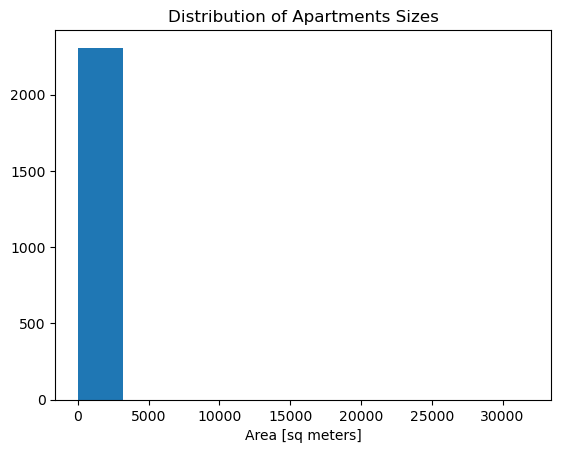

In [69]:
plt.hist(mexico_df['surface_covered_in_m2'])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartments Sizes");

## NOTE
This histogram has values ranging from 0 to 30_000 but seems to have been ploted in a small fraction. This indicates that there are outliers. To confirm this, a numerical exploration is done below

In [74]:
mexico_df.describe()['surface_covered_in_m2']

count    1910.000000
mean       77.341361
std        19.126381
min        50.000000
25%        61.000000
50%        74.000000
75%        90.000000
max       126.000000
Name: surface_covered_in_m2, dtype: float64

Above is the numerical exploration. The minimum area is 0 which does not make sense to sell an apartment that has 0 surface area. Looking at the median of the data, it shows that 50% of the apartments have a surface area of 75 and below but the maximum area is 31840 indicating a spread out data(skewwed)



In order to remove those extreme values of our dataset, we eliminate the bottom 10% and the top 10% in terms of area

Add to the wrangle function so that it removes observations that are outliers in the "surface_covered_in_m2" column. Specifically, all observations should fall between the 0.1 and 0.9 quantiles for "surface_covered_in_m2".

In [75]:
low, high = mexico_df['surface_covered_in_m2'].quantile([0.1,0.9])
mask_area = mexico_df['surface_covered_in_m2'].between(low, high)

## Updated Histogram with removed outliers

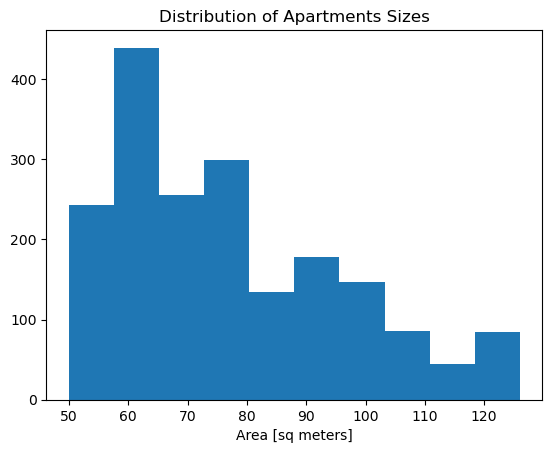

In [76]:
plt.hist(mexico_df['surface_covered_in_m2'])
plt.xlabel("Area [sq meters]")
plt.title("Distribution of Apartments Sizes");

In [79]:
mexico_df.shape

(1910, 16)

In [81]:
# Check your work
assert len(mexico_df) <= 1990